In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [300]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [320]:
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

## Обучающие данные

### Данные событий

In [37]:
events_data_train = pd.read_csv("../data/event_data_train.zip")

In [102]:
events_data_train.shape

(3480703, 6)

In [38]:
events_data_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [39]:
events_data_train.user_id.nunique()

19234

In [40]:
events_data_train['date'] = pd.to_datetime(events_data_train.timestamp, unit='s')

In [41]:
events_data_train['day'] = events_data_train.date.dt.date

In [46]:
events_data_train.step_id.nunique()

198

In [50]:
events_data_train.action.value_counts()

viewed             1830830
discovered          689495
passed              650331
started_attempt     310047
Name: action, dtype: int64

### Целевая переменная - наберёт ли пользователь более 40 баллов

In [243]:
count_data = events_data_train[events_data_train.action == 'passed'].groupby('user_id').action.count()

y_train_ = pd.DataFrame({'user_id' : np.sort(events_data_train.user_id.unique())})
y_train_ = y_train_.merge(count_data.to_frame(), on='user_id', how='outer').rename({'action' : 'q_passed'}, axis=1)

y_train_ = y_train_.fillna(0)

In [244]:
y_train_.user_id.nunique()

19234

In [245]:
y_train_['more_40'] = y_train_['q_passed'] > 40

In [246]:
y_train_[:10]

,user_id,q_passed,more_40
0,1,0.0,False
1,2,9.0,False
2,3,87.0,True
3,5,11.0,False
4,7,1.0,False
5,8,84.0,True
6,9,3.0,False
7,11,0.0,False
8,14,3.0,False
9,16,196.0,True


In [247]:
y_train_.more_40.value_counts()

False    14596
True      4638
Name: more_40, dtype: int64

In [248]:
y_train_.shape

(19234, 3)

### Данные посылок

In [42]:
submissions_data_train = pd.read_csv("../data/submissions_data_train.zip")

In [43]:
submissions_data_train['date'] = pd.to_datetime(submissions_data_train.timestamp, unit='s')

In [44]:
submissions_data_train['day'] = submissions_data_train.date.dt.date

In [45]:
submissions_data_train.user_id.nunique()

9940

In [47]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [48]:
submissions_data_train.step_id.nunique()

76

In [49]:
submissions_data_train.submission_status.value_counts()

wrong      286399
correct    222705
Name: submission_status, dtype: int64

### Отбираем данные - для каждого пользователя первые 2 дня

In [97]:
DATA_THRESHOLD = 2 * 24 * 60 * 60

In [92]:
user_min_time = events_data_train.groupby('user_id', as_index=False) \
                .agg({'timestamp' : 'min'}) \
                .rename({'timestamp' : 'min_timestamp'}, axis=1)

In [94]:
user_min_time.user_id.nunique()

19234

#### Данные событий

In [96]:
events_data_merged = events_data_train.merge(user_min_time, on='user_id', how='outer')

In [125]:
events_data_merged.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp,time_diff
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,0
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,47
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,47


In [124]:
events_data_merged['time_diff'] = events_data_merged['timestamp'] - events_data_merged['min_timestamp']

In [129]:
events_data_filtered = events_data_merged[events_data_merged.time_diff < DATA_THRESHOLD]

In [131]:
(events_data_merged.timestamp - events_data_merged.min_timestamp < DATA_THRESHOLD).value_counts()

False    2574509
True      906194
dtype: int64

In [130]:
events_data_filtered.shape

(906194, 8)

In [133]:
events_data_filtered.user_id.nunique()

19234

#### Данные посылок

In [151]:
submissions_data_train.user_id.nunique()

9940

In [152]:
user_min_time.user_id.nunique()

19234

In [162]:
submissions_data_merged = submissions_data_train.merge(user_min_time, on='user_id', how='inner')

In [163]:
submissions_data_merged.user_id.nunique()

9940

In [166]:
len(np.setdiff1d(user_min_time.user_id.unique(), submissions_data_train.user_id.unique()))

9294

In [167]:
len(np.setdiff1d(submissions_data_train.user_id.unique(),user_min_time.user_id.unique()      ))

0

In [168]:
submissions_data_merged['time_diff'] = submissions_data_merged['timestamp'] - submissions_data_merged['min_timestamp']

In [169]:
submissions_data_merged.user_id.nunique()

9940

In [170]:
submissions_data_filtered = submissions_data_merged[submissions_data_merged.time_diff < DATA_THRESHOLD]

In [171]:
submissions_data_filtered.user_id.nunique()

8815

### Формирование обучающей выборки

#### *Количество уникальных дней*

In [371]:
X = events_data_filtered.groupby('user_id').day.nunique().to_frame().reset_index() \
            .rename(columns={'day' : 'days'})

In [372]:
X.head()

,user_id,days
0,1,1
1,2,1
2,3,1
3,5,1
4,7,1


In [373]:
X.user_id.nunique()

19234

#### *Количество уникальных степов*

In [375]:
steps_tried = submissions_data_filtered.groupby('user_id').step_id.nunique().to_frame().reset_index() \
            .rename(columns={'step_id' : 'steps_tried'})

In [376]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [377]:
X = X.fillna(0)

In [378]:
X.head()

,user_id,days,steps_tried
0,1,1,0.0
1,2,1,2.0
2,3,1,4.0
3,5,1,0.0
4,7,1,0.0


In [379]:
X.days.value_counts()

1    14225
2     3420
3     1589
Name: days, dtype: int64

In [380]:
X.user_id.nunique()

19234

#### *Соотношение правильных и ошибочных посылок*

In [381]:
X = X.merge(submissions_data_filtered.pivot_table(index='user_id', 
                             columns='submission_status', 
                             values='step_id', aggfunc='count',
                             fill_value=0).reset_index(), how='outer')

In [382]:
X = X.fillna(0)

In [383]:
X.tail()

,user_id,days,steps_tried,correct,wrong
19229,26790,1,0.0,0.0,0.0
19230,26793,1,0.0,0.0,0.0
19231,26794,2,22.0,24.0,7.0
19232,26797,1,2.0,2.0,0.0
19233,26798,1,2.0,2.0,1.0


In [384]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [385]:
X = X.fillna(0)

#### *Количество просмотренных и пройденных стэпов*

In [386]:
X = X.merge(events_data_filtered.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index()[['user_id','viewed','passed']], how='outer')

In [387]:
X.user_id.nunique()

19234

In [388]:
X = X.merge(y_train_[['user_id', 'more_40']], how='outer')

In [389]:
X.user_id.nunique()

19234

In [390]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed,more_40
0,1,1,0.0,0.0,0.0,0.0,1,0,False
1,2,1,2.0,2.0,0.0,1.0,9,9,False
2,3,1,4.0,4.0,4.0,0.5,20,15,True
3,5,1,0.0,0.0,0.0,0.0,1,1,False
4,7,1,0.0,0.0,0.0,0.0,1,1,False


In [391]:
y = X.more_40
X = X.drop('more_40', axis=1)

In [392]:
X.shape

(19234, 8)

In [393]:
y.shape

(19234,)

In [394]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [395]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed,passed
user_id,,,,,,,
1,1,0.0,0.0,0.0,0.0,1,0
2,1,2.0,2.0,0.0,1.0,9,9
3,1,4.0,4.0,4.0,0.5,20,15
5,1,0.0,0.0,0.0,0.0,1,1
7,1,0.0,0.0,0.0,0.0,1,1


In [299]:
y.value_counts()

False    14596
True      4638
Name: more_40, dtype: int64

### Обучение

In [301]:
parameters = {
    'n_estimators' : range(10,52,10),
    'max_depth' : range(1,13,2),
    'min_samples_leaf' : range(1,8,3),
    'min_samples_split' : range(2,10,2)
}

In [302]:
clf = GridSearchCV(RandomForestClassifier(random_state=777), parameters, cv=3, n_jobs=-1)

In [303]:
clf.fit(X,y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=777,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'m

In [304]:
clf.best_score_

0.8555682645315587

In [305]:
clf.best_params_

{'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 40}

### Метрики качества

In [308]:
f1_score(y, clf.best_estimator_.predict(X))

0.657187176835574

In [321]:
confusion_matrix(y, clf.best_estimator_.predict(X))

array([[14040,   556],
       [ 2096,  2542]], dtype=int64)

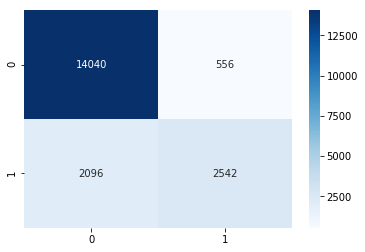

In [328]:
sns.heatmap(confusion_matrix(y, clf.best_estimator_.predict(X)), annot=True, cmap="Blues", fmt="d" );

In [314]:
fpr, tpr, thresholds = roc_curve(y, clf.best_estimator_.predict_proba(X)[:,1])

In [317]:
auc(fpr, tpr)

0.884860945321519

In [313]:
clf.best_estimator_.predict_proba(X)[:,1]

array([0.01843012, 0.27834989, 0.32730844, ..., 0.99914058, 0.278292  ,
       0.1887487 ])

### ROC curve

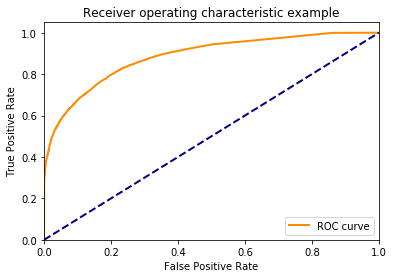

In [318]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

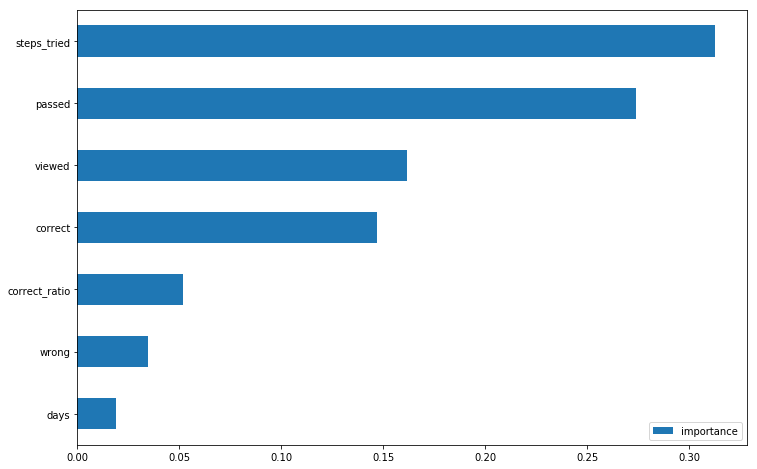

In [442]:
imp = pd.DataFrame(clf.best_estimator_.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

## Тестовые данные

### Данные событий

In [331]:
events_data_test = pd.read_csv("../data/contest_data/events_data_test.csv")

In [332]:
events_data_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [333]:
events_data_test.user_id.nunique()

6184

In [334]:
events_data_test.action.value_counts()

viewed             118276
discovered          67268
passed              62357
started_attempt     26867
Name: action, dtype: int64

In [335]:
events_data_test['date'] = pd.to_datetime(events_data_test.timestamp, unit='s')

In [336]:
events_data_test['day'] = events_data.date.dt.date

In [337]:
events_data_test.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


In [338]:
events_data_test.groupby('user_id').day.nunique().max()

3

### Данные посылок

In [340]:
submissions_data_test = pd.read_csv("../data/contest_data/submission_data_test.csv")

In [341]:
submissions_data_test.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [342]:
submissions_data_test.user_id.nunique()

2803

In [343]:
submissions_data_test['date'] = pd.to_datetime(submissions_data_test.timestamp, unit='s')

In [344]:
submissions_data_test['day'] = submissions_data_test.date.dt.date

In [345]:
submissions_data_test.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [346]:
submissions_data_test.groupby('user_id').day.nunique().max()

3

###  X_test

In [396]:
X_test = events_data_test.groupby('user_id').day.nunique().to_frame().reset_index() \
            .rename(columns={'day' : 'days'})

In [397]:
X_test.head()

,user_id,days
0,4,1
1,6,1
2,10,1
3,12,1
4,13,2


In [398]:
X_test.user_id.nunique()

6184

In [399]:
X_test = X_test.merge( \
            submissions_data_test.groupby('user_id').step_id.nunique().to_frame().reset_index() \
            .rename(columns={'step_id' : 'steps_tried'}) \
                      , on='user_id', how='outer')

In [400]:
X_test = X_test.fillna(0)

In [401]:
X_test.user_id.nunique()

6184

In [402]:
X_test = X_test.merge(submissions_data_test.pivot_table(index='user_id', 
                             columns='submission_status', 
                             values='step_id', aggfunc='count',
                             fill_value=0).reset_index(), how='outer')

In [403]:
X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)

In [404]:
X_test = X_test.fillna(0)

In [405]:
X_test.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,4,1,0.0,0.0,0.0,0.000000
1,6,1,0.0,0.0,0.0,0.000000
2,10,1,0.0,0.0,0.0,0.000000
3,12,1,1.0,1.0,0.0,1.000000
4,13,2,29.0,29.0,36.0,0.446154


In [406]:
X_test = X_test.merge(events_data_test.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                       fill_value=0).reset_index()[['user_id','viewed','passed']], how='outer')

In [407]:
X_test.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed
0,4,1,0.0,0.0,0.0,0.000000,1,1
1,6,1,0.0,0.0,0.0,0.000000,1,1
2,10,1,0.0,0.0,0.0,0.000000,6,2
3,12,1,1.0,1.0,0.0,1.000000,14,9
4,13,2,29.0,29.0,36.0,0.446154,105,70


In [408]:
X_test.shape

(6184, 8)

In [409]:
X_test.isnull().sum()

user_id          0
days             0
steps_tried      0
correct          0
wrong            0
correct_ratio    0
viewed           0
passed           0
dtype: int64

In [410]:
X_test = X_test.set_index(X_test.user_id)
X_test = X_test.drop('user_id', axis=1)

In [411]:
X_test.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed,passed
user_id,,,,,,,
4,1,0.0,0.0,0.0,0.000000,1,1
6,1,0.0,0.0,0.0,0.000000,1,1
10,1,0.0,0.0,0.0,0.000000,6,2
12,1,1.0,1.0,0.0,1.000000,14,9
13,2,29.0,29.0,36.0,0.446154,105,70


In [412]:
y_test_pred = clf.best_estimator_.predict_proba(X_test)

In [413]:
y_test_pred[:10]

array([[9.57417750e-01, 4.25822505e-02],
       [9.57417750e-01, 4.25822505e-02],
       [8.92710265e-01, 1.07289735e-01],
       [7.88257094e-01, 2.11742906e-01],
       [2.20013510e-04, 9.99779986e-01],
       [6.43543485e-01, 3.56456515e-01],
       [9.57417750e-01, 4.25822505e-02],
       [9.79876161e-03, 9.90201238e-01],
       [9.57417750e-01, 4.25822505e-02],
       [4.54773584e-01, 5.45226416e-01]])

In [414]:
y_test_pred.shape

(6184, 2)

### Результат

In [424]:
result = pd.DataFrame({'user_id' : X_test.index, 'is_gone' : y_test_pred[:,1]})

In [426]:
result.head()

,user_id,is_gone
0,4,0.042582
1,6,0.042582
2,10,0.107290
3,12,0.211743
4,13,0.999780


In [427]:
result.tail()

,user_id,is_gone
6179,26791,0.042582
6180,26795,0.042582
6181,26796,0.133049
6182,26799,0.176631
6183,26800,0.018430


In [441]:
result.to_csv('../data/result.csv', sep=',', index=False, float_format="%.4f")